# InSAR resolution visualization tool

Gareth Funning, University of California, Riverside

An attempt to visualize what it looks like to render a 3D deformation model into InSAR line-of-sight at different resolutions

## 0. Load dependencies

This notebook makes use of dependencies that should already be installed if you installed pygmt with conda (pandas, numpy and gdal).

In [1]:
# dependencies
import pandas as pd
import numpy as np
import pygmt

## 1. Define the inputs

Here we make use of model displacements (from a FLAC model, say), as well as some of the files produced when processing an interferogram. We also specify here what the desired resolution of the downsampled displacements will be.

In [55]:
# we need a file containing model displacements
infile='./FLAC_disp_1in_12dy.csv'

# and some files that quantify the InSAR viewing geometry (produced by the hyp3 processor)
phifile='./S1_290247_IW2_20211125_20211207_VV_INT20_2F31_lv_phi.tif'
thetafile='./S1_290247_IW2_20211125_20211207_VV_INT20_2F31_lv_theta.tif'

# what is your target resolution?
max_res=20

And we can look at some of these things if you are curious:

In [56]:
# if you are curious about the InSAR viewing geometry files, we can look at them with gdal (uncomment line below)
#!gdalinfo $phifile

The useful thing here is that the hyp3 system produces interferograms already projected into UTM coordinates, so that we can use these files with our model displacements without any need for reprojection!

(If you need to reproject files, the command 'gdalwarp' is the way to do that.)

## 2. Load in the model, sample the line-of-sight data and estimate vector components

Here we load in the model displacements, clean up the data table and use the pygmt 'grdtrack' command to sample the elevation angle (theta) and pointing azimuth (phi) information on line-of-sight (LOS) at the locations of our modeled points. And then we can compute the LOS vector components, and use these to project the model into LOS displacement. (Note that we are reporting the LOS components in ground displacement $-$ the convention used in MintPy.)

In [57]:
# load in the model
model_displ=pd.read_csv(infile)

# get rid of the original first column, so that x and y location are the first two columns (expected by GMT)
model_displ=model_displ.drop(labels="Gridpoint",axis=1)

# sample the phi and theta values for your datapoints (requires x and y location in the first two columns of model_displ)
model_displ=pygmt.grdtrack(phifile,points=model_displ,newcolname='phi')
model_displ=pygmt.grdtrack(thetafile,points=model_displ,newcolname='theta')

In [58]:
# optionally, see what you loaded in and sampled (uncomment line below)
#model_displ  

In [59]:
# convert phi and theta to LOS vector components
losx=np.cos(model_displ["phi"])*np.cos(model_displ["theta"])
losy=np.sin(model_displ["phi"])*np.cos(model_displ["theta"])
losz=np.sin(model_displ["theta"])

# report the ranges of values as a sanity check (should be ground displacement convention, pointing from ground target to the satellite)
print("ranges of LOS vector components:")
print("los x: {0:f} to {1:f}".format(np.min(losx),np.max(losx)))
print("los y: {0:f} to {1:f}".format(np.min(losy),np.max(losy)))
print("los y: {0:f} to {1:f}".format(np.min(losz),np.max(losz)))
      
# calculate LOS displacement by scaling each displacement component by the LOS vector component, and adding together
losdisp=losx*model_displ["X_disp_mm"]+losy*model_displ["Y_disp_mm"]+losz*model_displ["Z_disp_mm"]

ranges of LOS vector components:
los x: -0.603445 to -0.602897
los y: -0.108441 to -0.108413
los y: 0.789996 to 0.790418


In [60]:
# also optionally, see the projected line-of-sight displacement (uncomment line below)
#losdisp

## 3. Plot the model at full resolution

Estimate bounds for your plot and the range of your displacement values, and then plot all your points, color-coded by displacement.

In [61]:
# model bounds
minx=model_displ["X_m"].min()
maxx=model_displ["X_m"].max()
miny=model_displ["Y_m"].min()
maxy=model_displ["Y_m"].max()

minx=(np.floor(minx/max_res)*max_res).astype(int)
miny=(np.floor(miny/max_res)*max_res).astype(int)
maxx=(np.ceil(maxx/max_res)*max_res).astype(int)
maxy=(np.ceil(maxy/max_res)*max_res).astype(int)

print("Rounded plot bounds: {0:d}/{1:d}/{2:d}/{3:d}".format(minx,maxx,miny,maxy))
print("Plot dimensions: {0:d} x {1:d}".format(maxx-minx,maxy-miny))

Rounded plot bounds: 569320/569980/5209320/5210000
Plot dimensions: 660 x 680


In [62]:
# displacemnt values

minvel=np.floor(losdisp.min())
#minvel=-1
maxvel=np.ceil(losdisp.max())
#axvel=1
print("Displacement bounds: {0:f} to {1:f}".format(minvel,maxvel))

Displacement bounds: -21.000000 to 1.000000


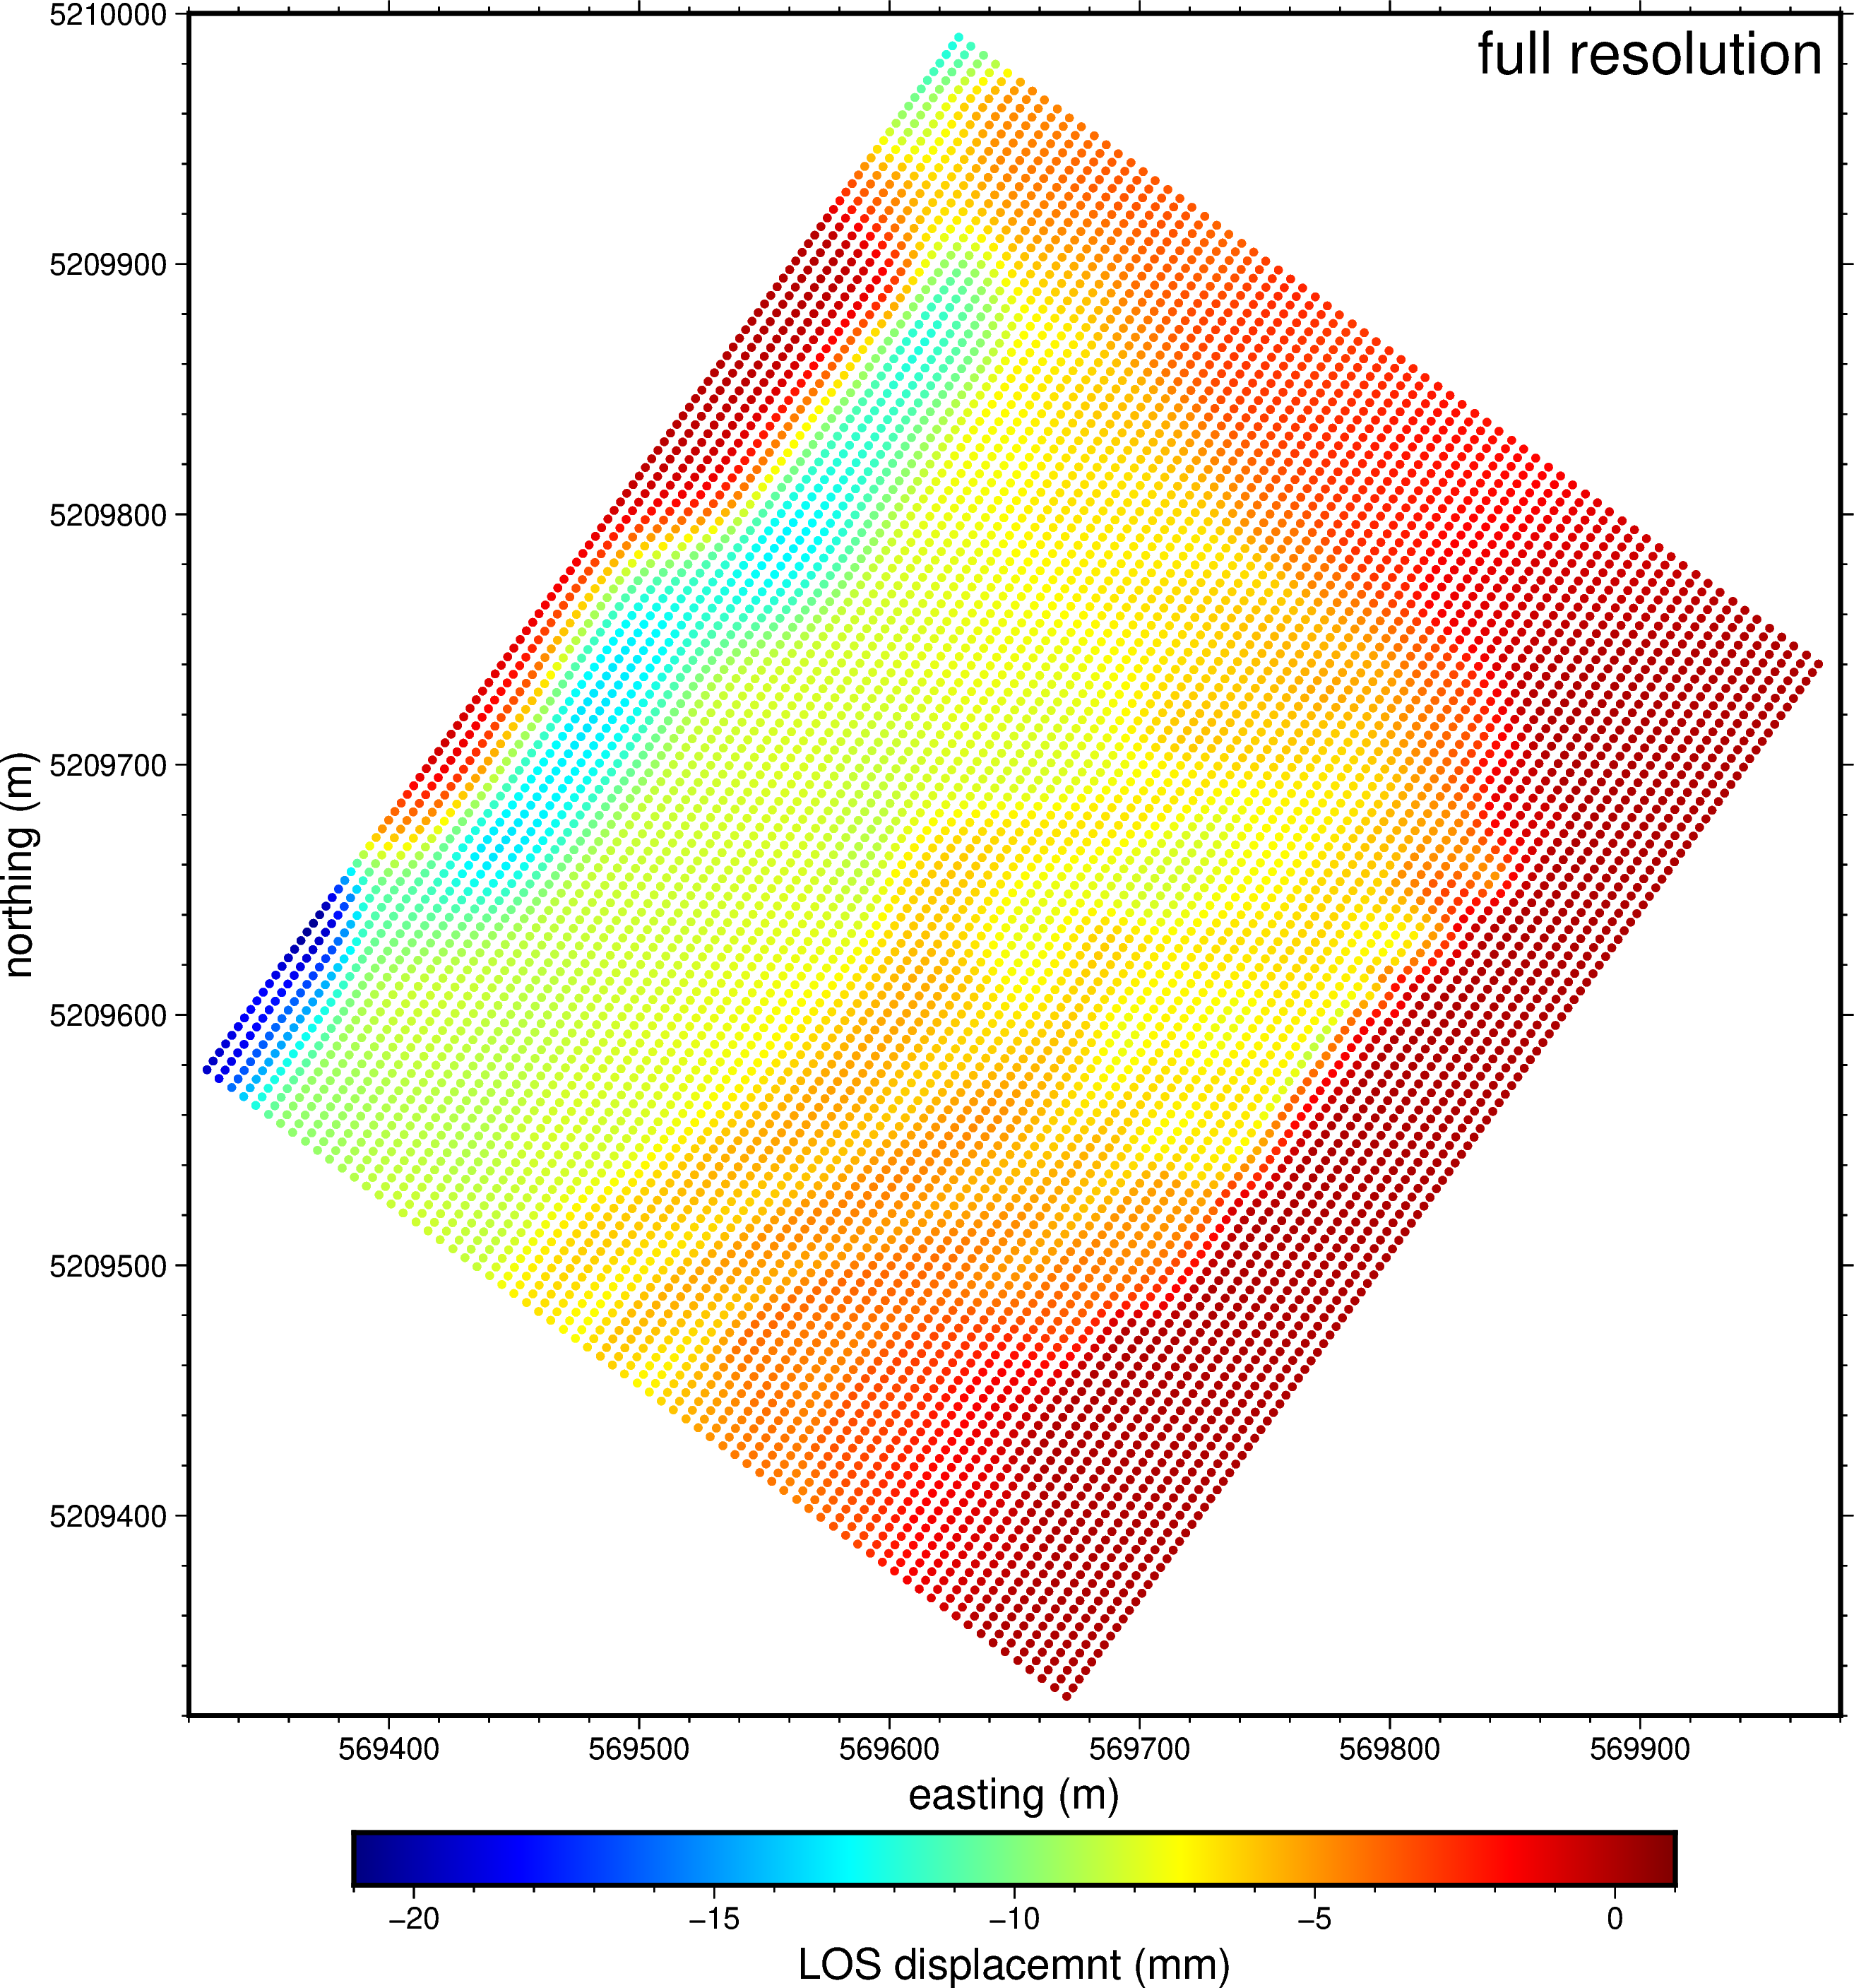

In [63]:
# plot the data

plotarea="{0:d}/{1:d}/{2:d}/{3:d}".format(minx,maxx,miny,maxy)
pygmt.config(COLOR_NAN="white")

fig=pygmt.Figure()
fig.basemap(region=plotarea,
            projection="x0.03c",
            frame=["WeSn", "xaf+leasting (m)", "yaf+lnorthing (m)"],
           )
pygmt.config(COLOR_NAN="white")
pygmt.makecpt(cmap="jet", series=[minvel, maxvel])
fig.plot(x=model_displ.X_m, 
         y=model_displ.Y_m,
         fill=losdisp,
         cmap=True,
         style="c0.1c",
        )
fig.text(position='TR', text='full resolution', justify='TR', font='20p', offset='-0.2c')
fig.colorbar(frame='af+lLOS displacement (mm)')
fig.show()
fig.savefig('full_resolution.png')

## 4. Downsample the model displacements, and plot them 

Finally, we will use the pygmt 'blockmean' command to spatially average the model LOS displacements at our target resolution, to simulate the multilooking process used in InSAR. We convert these averaged displacements to a raster file using the 'xyz2grd' command, and plot them using 'grdimage'. With that, you should have a fair idea of the deformation features that InSAR might be able to resolve.

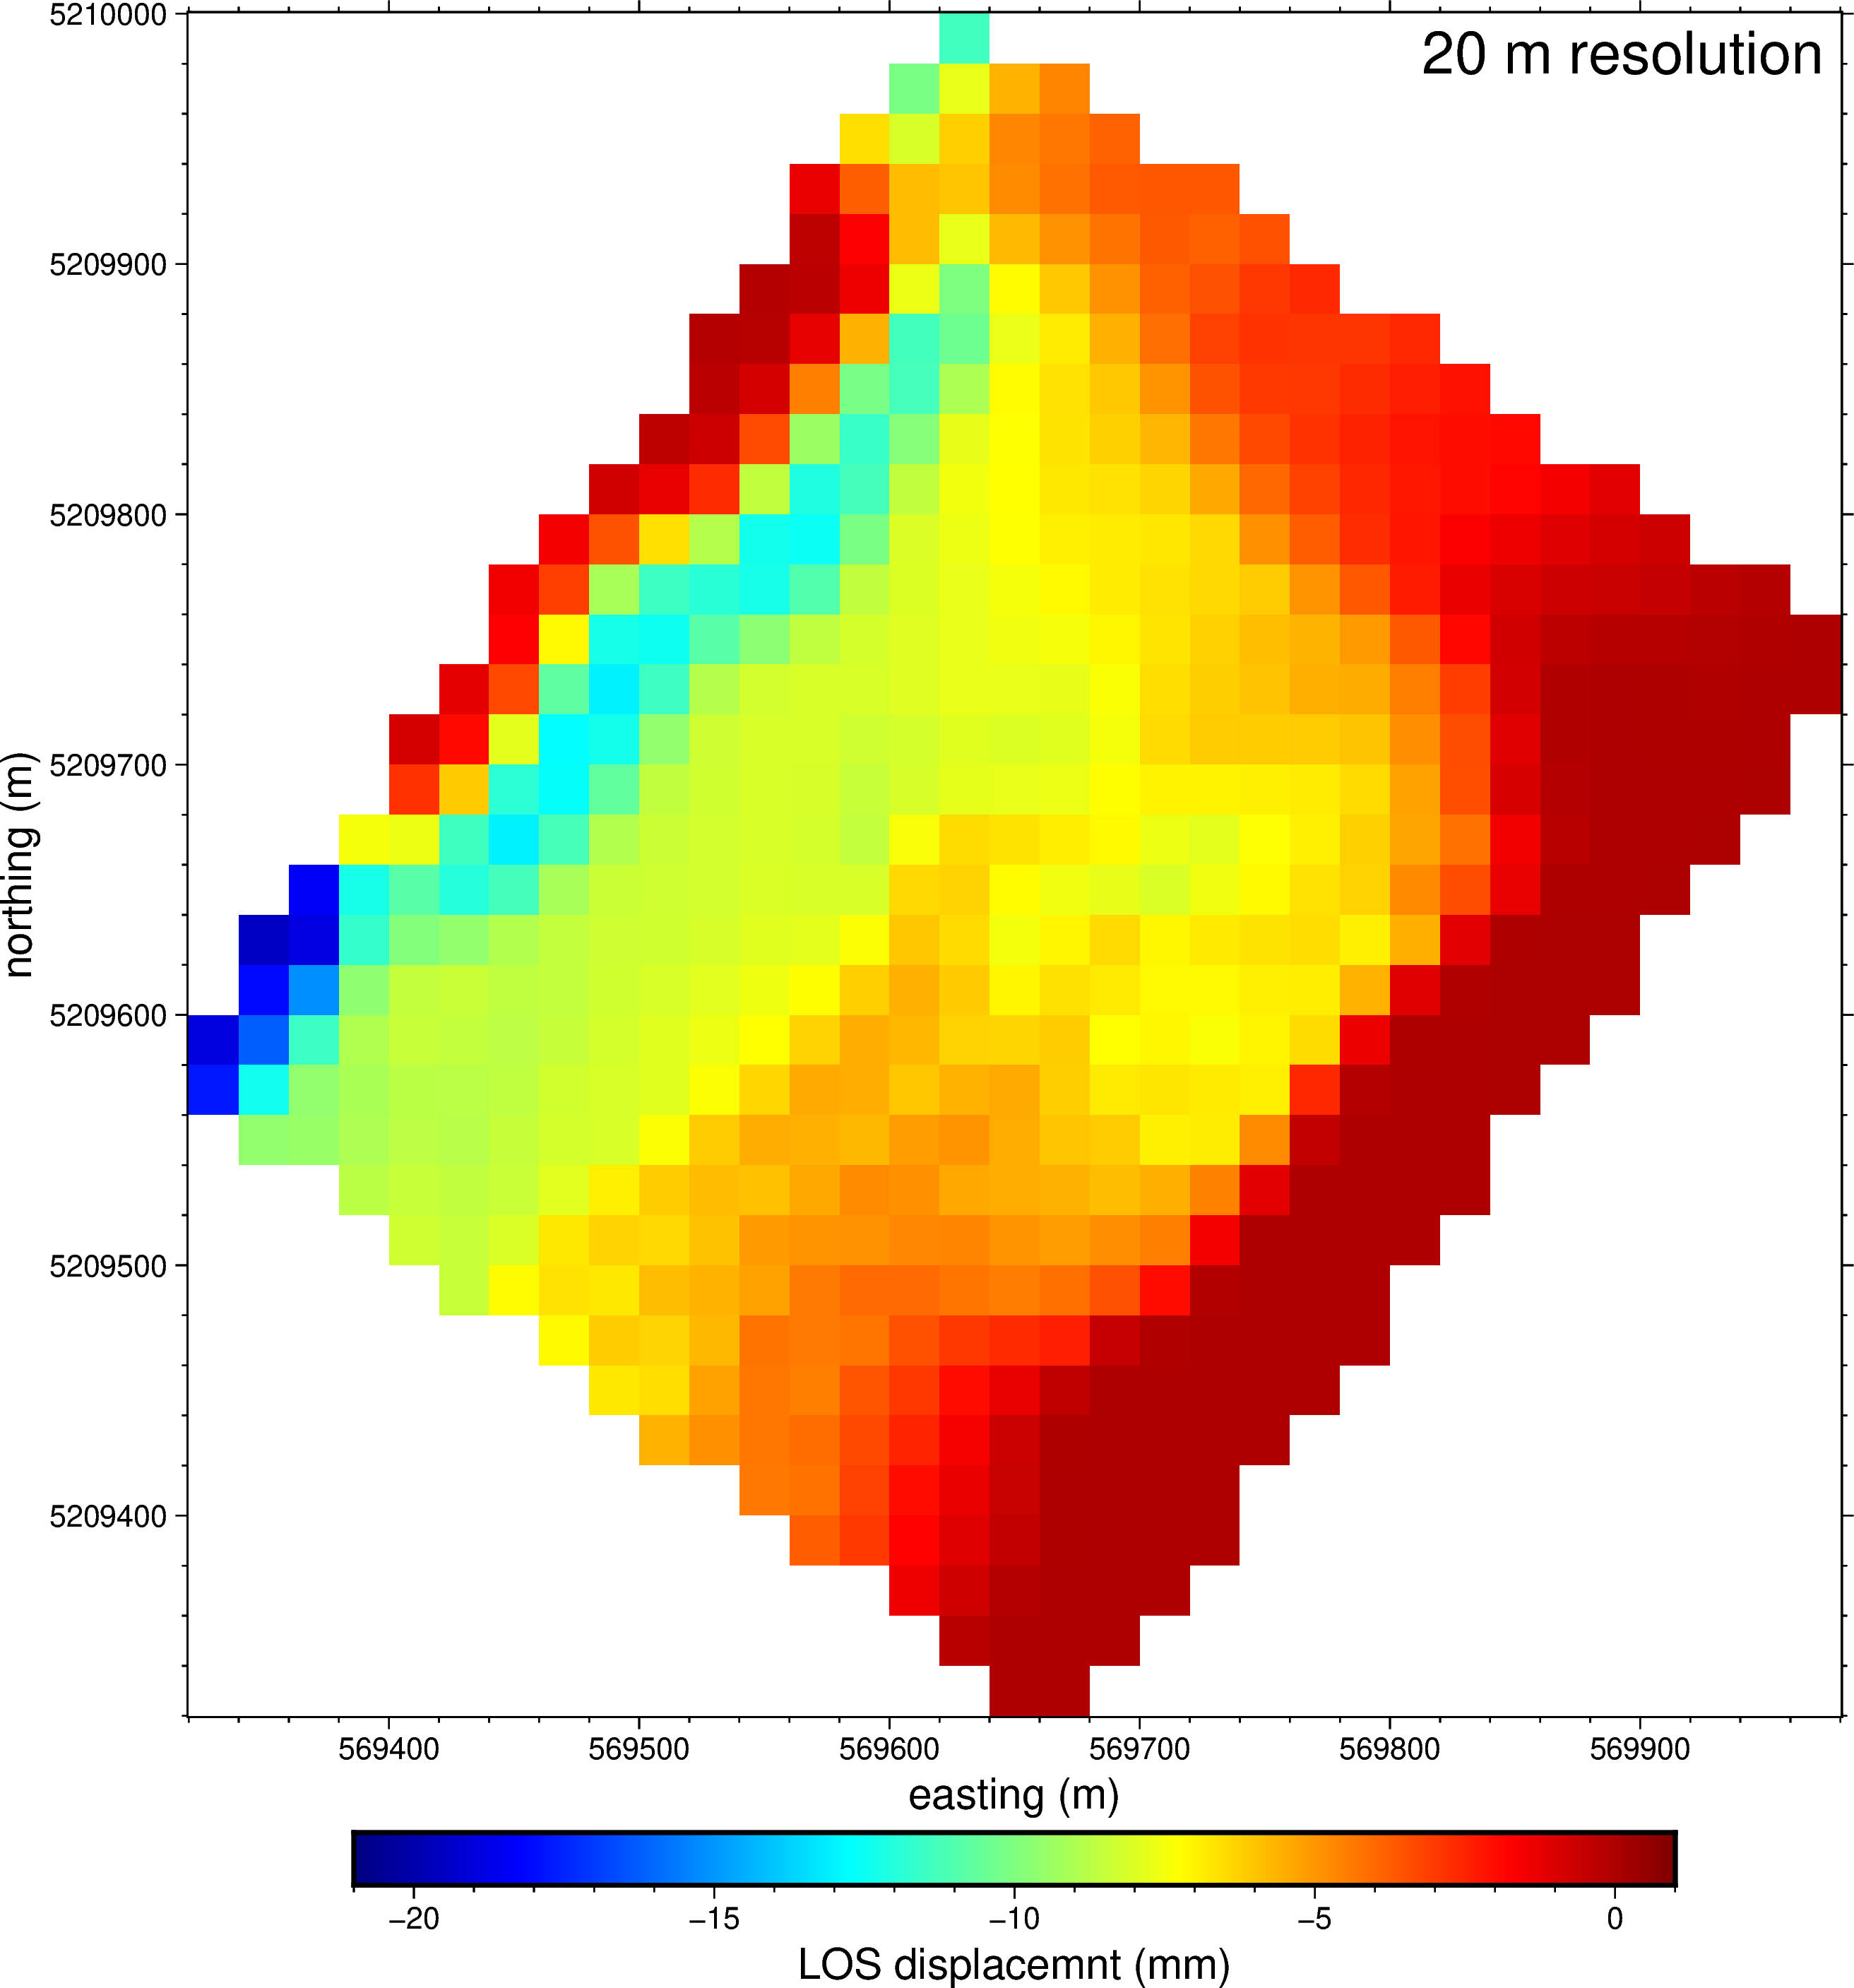

In [64]:
# let's try to downsample this thing
dsmpl=pygmt.blockmean(x=model_displ.X_m, 
                   y=model_displ.Y_m,
                   z=losdisp,
                   spacing=max_res,
                   registration='p',
                   region=plotarea)

dsmpl.columns=['x','y','z']

# make a raster file out of it
pygmt.xyz2grd(data=dsmpl,
                   spacing=max_res,
                   region=plotarea,
                   registration='p',
                   outgrid='downsampled.nc')
                               
# and plot it
fig=pygmt.Figure()
fig.basemap(region=plotarea,projection="x0.03c",frame=["WeSn", "xaf+leasting (m)", "yaf+lnorthing (m)"])
pygmt.config(COLOR_NAN="white")
pygmt.makecpt(cmap="jet", series=[minvel, maxvel], background="i", overrule_bg=True)
fig.grdimage('downsampled.nc',cmap=True)
fig.text(position='TR', text='{0:d} m resolution'.format(max_res), justify='TR', font='20p', offset='-0.2c')
fig.colorbar(frame='af+lLOS displacement (mm)')
fig.show()
fig.savefig('downsampled_{0:d}m.png'.format(max_res))